## 데이터 불러오기

In [1]:
!pip install konlpy
!pip install pyLDAvis
#!pip install chatspace

     |████████████████████████████████| 19.4MB 45.7MB/s 
     |████████████████████████████████| 460kB 45.6MB/s 
     |████████████████████████████████| 92kB 8.0MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
     |████████████████████████████████| 1.6MB 9.3MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=c3bc0f1d780f6c4c2ae5b11918e0e0574d866596c02187ee8fc2fc4e1323d212
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [2]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
## Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
# from pprint import pprint
# Plotting tools
# import pyLDAvis
# import pyLDAvis.sklearn

import konlpy
from konlpy.tag import Komoran
import konlpy.tag
import nltk

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

# ## 워드클라우드
# import operator

# !apt-get install fonts-nanum*
# !apt-get install fontconfig
# %matplotlib inline
# !pip install wordcloud

# from matplotlib import pyplot
# from wordcloud import WordCloud
# FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# # 띄어쓰기
# import chatspace

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
df=pd.read_excel('/content/drive/Shareddrives/[논문] 내 외국인관광객 유동인구 비교/분석/전처리/명소_외국인_이름정리.xlsx')

In [6]:
df

,name,date,reviews,stars,category,address,lat,lng,foreigner
0,아양교,1921.1.18,"옛 철도 다리가 커피 숍을 열었습니다, 당신은 앉아서 음료와 먹는 얼음을 가지고,...",3,관광 명소,대구광역시 동구 지저동 930,35.890314,128.638354,1
1,아양교,1921.1.18,여유롭게 산책하기에 좋은 곳\n특히 밤에는 반사가 아름답습니다.\n\n\n是個悠閒...,4,관광 명소,대구광역시 동구 지저동 930,35.890314,128.638354,1
2,아양교,1921.1.18,"지하철에서 나와서 아양 철도로가는 길에, 밤의 장면은 정말 아름답습니다. 밤이긴하...",5,관광 명소,대구광역시 동구 지저동 930,35.890314,128.638354,1
3,아양교,1921.1.18,벚꽃이 만발하면 아름다운 벚꽃 터널처럼 보입니다.\n\n\n櫻花盛開時，非常狀觀漂亮...,5,관광 명소,대구광역시 동구 지저동 930,35.890314,128.638354,1
4,아양교,1921.1.18,아름다운 대목장 ~ 대구 아양요 길 ~ ~ 여기에서 사는 많은 사람들을 볼 수있다...,5,관광 명소,대구광역시 동구 지저동 930,35.890314,128.638354,1
...,...,...,...,...,...,...,...,...,...
3510,청라언덕,2019년 7월,천천히 시간을 느낄 수있는 곳입니다. 서문시장에서 도보로 지하철 센트럴 역에가는 길...,5,NaN,대구광역시 달성군 가창면 우록길 206,35.723341,128.647189,1
3511,달성한일우호관,2016년 10월,택시로 갔다 중심부에서 떨어져 있기 때문에 택시로갔습니다. 미터 15000w 이었지...,5,NaN,대구광역시 달성군 가창면 우록길 206,35.723341,128.647189,1
3512,달성한일우호관,2016년 6월,도심에서 멀리 떨어진 전시관은 대구 시티 투어의 수창 노선 (예약 필수매우 비용 효...,5,NaN,대구광역시 달성군 가창면 우록길 206,35.723341,128.647189,1
3513,달성한일우호관,2012년 7월,달성군 한일 우호 관 (김충선 기념관) 대구시의 교외에있는 친구 鹿里라고 마을에 다...,4,NaN,대구광역시 달성군 가창면 우록길 206,35.723341,128.647189,1


In [7]:
print('before dropping duplicates: ', df.shape)
df1=df.drop_duplicates()
print('after dropping duplicates: ', df1.shape)

before dropping duplicates:  (3515, 9)
after dropping duplicates:  (3515, 9)


In [8]:
df1['reviews'] = df1['reviews'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]", "")

In [9]:
print('before dropping null reviews: ', df1.isna().sum()['reviews'])
df1 = df1.dropna(subset = ['reviews'])
print('after dropping null reviews: ', df1.isna().sum()['reviews'])

before dropping null reviews:  0
after dropping null reviews:  0


##Making Dictionary

In [10]:
from gensim.corpora import Dictionary
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from konlpy.tag import Okt
import gensim
from konlpy.tag import Mecab 
from tqdm import tqdm 
import re 
from gensim.models.ldamodel import LdaModel 
from gensim.models.callbacks import CoherenceMetric 
from gensim import corpora 
from gensim.models.callbacks import PerplexityMetric 
import logging 
import pickle 
import pyLDAvis.gensim 
from gensim.models.coherencemodel import CoherenceModel 
import matplotlib.pyplot as plt
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip
!pip install -U gensim

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
--2021-02-04 06:12:52--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  6.32MB/s    in 2.4s    

2021-02-04 06:12:55 (6.32 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepe

In [11]:
stopwords=['구글', '번역', '제공', '원문', '한국', '매우', '대구', '사람', '때문', '생각', '아주','거기','여기','그것','타고', '가지','다른','또한','우리','정도','시간','모든','정말','가장','조금']
similarwords = {'돈가스': '돈까스'}

topic 0 :  0.237*"대구" + 0.154*"공원" + 0.071*"도시" + 0.060*"지역" + 0.048*"가장" + 0.045*"건물" + 0.043*"거리" + 0.040*"타워"  
topic 1 :  0.133*"한국" + 0.073*"시장" + 0.069*"아주" + 0.060*"모든" + 0.058*"음식" + 0.057*"다른" + 0.052*"정말" + 0.046*"전통"  
topic 2 :  0.216*"매우" + 0.136*"장소" + 0.099*"사람" + 0.086*"사진" + 0.067*"교회" + 0.055*"여기" + 0.055*"산책" + 0.040*"주변"  
topic 3 :  0.075*"버스" + 0.058*"사원" + 0.054*"케이블카" + 0.053*"전망" + 0.038*"풍경" + 0.033*"타고" + 0.031*"여행" + 0.030*"카페"  
topic 4 :  0.141*"방문" + 0.100*"시간" + 0.072*"우리" + 0.068*"가치" + 0.065*"그것" + 0.060*"아이" + 0.041*"가지" + 0.038*"생각"  
topic 5 :  0.105*"박물관" + 0.086*"역사" + 0.079*"무료" + 0.044*"경험" + 0.044*"영어" + 0.040*"때문" + 0.039*"사용" + 0.037*"위해"  

In [12]:
Data_list = df1['reviews'].tolist()
data_word = []
okt = Okt()
for i in range(len(Data_list)):
  try:
    words = okt.nouns(Data_list[i])
    item = []
    for word in words:
      if word not in stopwords and len(word)>1:
        if word in similarwords:
          item.append(similarwords[word])
        else:
          item.append(word)
    data_word.append(item)
  except Exception as e:
    print('Exception')
    continue
  # data_word.append(okt.nouns(Data_list[i]))

In [13]:
id2word = Dictionary(data_word)
id2word.filter_extremes(no_below=20)
texts = data_word
corpus = [id2word.doc2bow(text) for text in texts]
mallet_path = 'mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [14]:
!pip install tqdm

In [15]:
from tqdm import tqdm

In [16]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

def compute_coherence_values(dictionary, corpus, texts, limit, start=4, step=2):
    perplexity_values = []
    # perplexity_diff_values = []
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit+1, step)):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=data_word, dictionary=dictionary, coherence='c_v')
        #Compute Coherence
        coherence_values.append(coherencemodel.get_coherence())
        # Compute Perplexity-perplexity=2^(-bound)
        bound = lda_model.log_perplexity(corpus)
        perplexity_values.append(2**(-1*bound))
        # if len(perplexity_values)>1:
        #   perplexity_diff_values.append(perplexity_values[-1]-perplexity_values[-2])
    np_per = np.array(perplexity_values)
    perplexity_diff_values = (np_per[:-1]-np_per[1:]).tolist()
    return model_list, coherence_values, perplexity_values, perplexity_diff_values

limit=20
start=3
step=1

# Can take a long time to run.
model_list, coherence_values, perplexity_values, perplexity_diff_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter

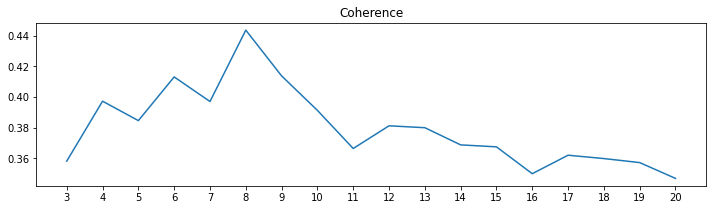

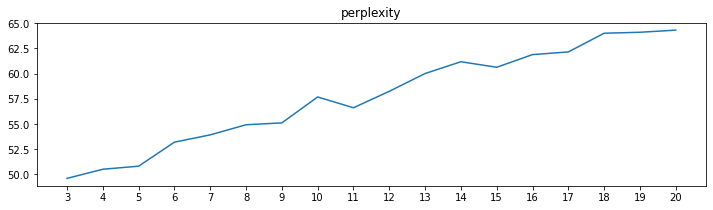

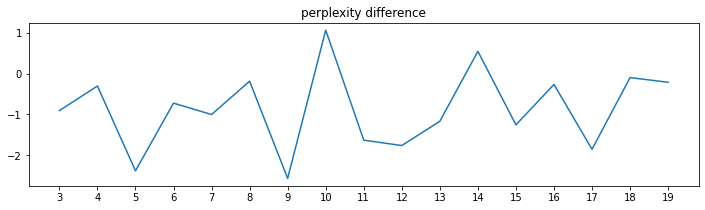

In [18]:
x = range(start, limit, step)
topic_num = 0
count = 0
max_coherence = 0
for m, cv in zip(x, coherence_values):
    # print("Num Topics =", m, " has Coherence Value of", cv)
    coherence = cv
    if coherence >= max_coherence:
        max_coherence = coherence
        topic_num = m
        model_list_num = count   
    count = count+1
        
# Select the model and print the topics
optimal_model = model_list[model_list_num]
model_topics = optimal_model.show_topics(formatted=False)

x = ["{}".format(i) for i in range(start, limit+1)]
plt.figure(figsize=(12, 3))
plt.plot(x, coherence_values)

plt.title('Coherence')
plt.show()
# 토픽 개수별 perpFlexity
x = ["{}".format(i) for i in range(start, limit+1)]
plt.figure(figsize=(12, 3))
plt.plot(x, perplexity_values)
plt.title('perplexity')
plt.show()
# 토픽 개수별 perplexity difference
x = ["{}".format(i) for i in range(start, limit)]
plt.figure(figsize=(12, 3))
plt.plot(x, perplexity_diff_values)
plt.title('perplexity difference')
plt.show()
# print(topic_num)
# print(len(model_topics))


In [52]:
x = ["{}".format(i) for i in range(start, limit+1)]
fig, axes = plt.subplots(1,1)
ax = sns.lineplot(x=x,y=coherence_values)
axes.title
fig.set_size_inches((12,3))
data_x, data_y = ax.lines[0].get_data()
xi = 6-3
yi = np.interp(xi,data_x, data_y)
axes.plot([xi],[yi], marker="o")
axes.plot([xi,xi],[0.33,yi],color='r')

# plt.figure(figsize=(12, 3))
# plt.plot(x, coherence_values)

# plt.title('Coherence')


# plt.show()


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f558ceeea60> (for post_execute):


AttributeError: ignored

AttributeError: ignored

<Figure size 864x216 with 1 Axes>

In [43]:
data_y.min()

0.3468935367608838

In [39]:
data_x

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17.])

In [34]:
data_x, data_y = ax.lines[0].get_data()

In [37]:
xi = 6
yi = np.interp(xi,data_x, data_y)
axes.plot([xi],[yi], marker="o")
axes.plot([xi,xi],[0,yi],color='r')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


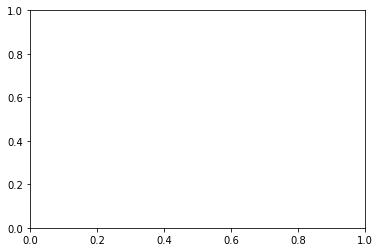

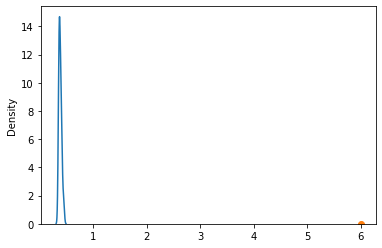

In [22]:
import seaborn as sns
fig, axes = plt.subplots(1,1)

  #  ch1,ch2 = st.beta_columns([2.5,1])
  #   my_expander2 = st.beta_expander(label = '기존 식수인원 대비 분포도')
  #   my_expander2.markdown("<p class='small-font'> * 해당 분포도는 과거 데이터의 분포에서 예측식수인원이 어디에 위치하는지 보여줍니다.</div>", unsafe_allow_html=True)
# 분포도
fig, axes = plt.subplots(1,1)
ax=sns.distplot(coherence_values,hist=False,ax=axes)
data_x, data_y = ax.lines[0].get_data()

xi = 6
yi = np.interp(xi,data_x, data_y)
axes.plot([xi],[yi], marker="o")
axes.plot([xi,xi],[0,yi],color='r')
# 토픽 개수별 실제 Coherence

In [ ]:
topics = model_list[10].print_topics(num_words=8)
for topic in topics:
  print('topic', topic[0], ': ', topic[1].split('0.000')[0]) 

topic 0 :  0.174*"버스" + 0.070*"정도" + 0.067*"지하철" + 0.051*"관광" + 0.051*"시내" + 0.045*"투어" + 0.043*"도착" + 0.038*"관광객"
topic 1 :  0.198*"박물관" + 0.131*"무료" + 0.064*"영어" + 0.060*"전시" + 0.047*"체험" + 0.043*"설명" + 0.039*"일본어" + 0.036*"한약"
topic 2 :  0.150*"케이블카" + 0.129*"도시" + 0.109*"전망" + 0.082*"등산" + 0.065*"경치" + 0.058*"여행" + 0.055*"앞산" + 0.047*"최고"
topic 3 :  0.176*"시장" + 0.141*"음식" + 0.070*"전통" + 0.065*"가게" + 0.052*"가격" + 0.045*"상점" + 0.043*"서문시장" + 0.039*"포장마차"
topic 4 :  0.190*"시간" + 0.142*"거리" + 0.100*"모든" + 0.094*"건물" + 0.047*"경우" + 0.047*"거의" + 0.045*"예술" + 0.043*"현대"
topic 5 :  0.107*"타워" + 0.087*"정말" + 0.063*"레스토랑" + 0.061*"풍경" + 0.053*"가족" + 0.049*"티켓" + 0.049*"저녁" + 0.042*"놀이기구"
topic 6 :  0.099*"가장" + 0.085*"하나" + 0.079*"경험" + 0.062*"위해" + 0.053*"벚꽃" + 0.051*"사용" + 0.043*"운동" + 0.041*"동안"
topic 7 :  0.124*"사원" + 0.084*"주변" + 0.068*"위치" + 0.061*"모두" + 0.044*"약간" + 0.041*"언덕" + 0.040*"여러" + 0.036*"팔공산"
topic 8 :  0.236*"장소" + 0.148*"사진" + 0.075*"카페" + 0.050*"재미" + 0.049*"친구" + 0.045

topic 0 :  0.117*"시장" + 0.096*"모든" + 0.092*"음식" + 0.086*"다른" + 0.073*"전통" + 0.070*"가장" + 0.060*"한국" + 0.050*"가격"
topic 1 :  0.170*"사람" + 0.132*"한국" + 0.081*"경험" + 0.078*"영어" + 0.065*"위해" + 0.060*"조금" + 0.056*"문화" + 0.042*"대해"
topic 2 :  0.170*"박물관" + 0.141*"역사" + 0.129*"무료" + 0.057*"건물" + 0.045*"한복" + 0.045*"설명" + 0.045*"체험" + 0.042*"정보"
topic 3 :  0.248*"방문" + 0.119*"가치" + 0.116*"교회" + 0.100*"사원" + 0.069*"주변" + 0.062*"하나" + 0.047*"명소" + 0.031*"다리"
topic 4 :  0.267*"공원" + 0.105*"지역" + 0.095*"여기" + 0.056*"위치" + 0.053*"휴식" + 0.049*"나무" + 0.047*"공간" + 0.043*"동안"
topic 5 :  0.110*"도시" + 0.084*"케이블카" + 0.083*"전망" + 0.062*"타워" + 0.059*"풍경" + 0.051*"타고" + 0.047*"카페" + 0.044*"하이킹"
topic 6 :  0.148*"시간" + 0.128*"아주" + 0.087*"또한" + 0.085*"정말" + 0.065*"생각" + 0.054*"커피" + 0.047*"가족" + 0.042*"벚꽃"
topic 7 :  0.122*"버스" + 0.066*"거리" + 0.066*"때문" + 0.065*"사용" + 0.059*"지하철" + 0.052*"경우" + 0.036*"전체" + 0.035*"이용"
topic 8 :  0.226*"장소" + 0.145*"사진" + 0.107*"아이" + 0.093*"산책" + 0.047*"운동" + 0.040*"마을" + 0.034*"사랑" + 0.034*"촬영"

## 토픽모델링 데이터프레임 형태로 저장
- 위도, 경도 붙이기

In [ ]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    #ldamodel[corpus]: lda_model에 corpus를 넣어 각 토픽 당 확률을 알 수 있음
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num,topn=10)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    print(type(sent_topics_df))

    # Add original text to the end of the output
    #contents = pd.Series(texts)
    #sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df = pd.concat([sent_topics_df, df1], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=Data_list)
topics = df_topic_sents_keywords['Dominant_Topic'].value_counts()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:471: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


<class 'pandas.core.frame.DataFrame'>


In [ ]:
topics

0.0    908
2.0    668
1.0    529
4.0    517
3.0    495
5.0    455
Name: Dominant_Topic, dtype: int64

In [ ]:
df_topic_sents_keywords = df_topic_sents_keywords[['name', 'date', 'reviews', 'stars', 'category', 'address', 'lat', 'lng','foreigner', 'Dominant_Topic']]

In [ ]:
df_topic_sents_keywords.to_csv('/content/drive/MyDrive/대구 관광 분석/분석/LDA/LDA_현유_결과/LDA_맛집.csv', index=False, encoding='cp949')